In [1]:
#https://github.com/Kulbear/stock-prediction/blob/master/stock-prediction.ipynb
import time
import math
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Concatenate
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def build_model(size, window, num_neurons, out_dim, D = [0.1, 0.1, 0.1]):
    #Create RNN
    RNN = Sequential()
    #First LSTM Layer
    RNN.add(LSTM(num_neurons[0], input_shape=(window, size),
                 return_sequences = True, dropout = D[0]))
    RNN.add(Activation('relu'))
    
    #Second LSTM Layer
    RNN.add(LSTM(num_neurons[1], return_sequences=True, dropout = D[1]))
    RNN.add(Activation('tanh'))
    
    #Third LSTM Layer
    RNN.add(LSTM(num_neurons[2], return_sequences=False, dropout = D[2]))
    RNN.add(Activation('relu'))

    #First Dense Layer
    RNN.add(Dense(num_neurons[3]))
    RNN.add(Activation('tanh'))
    
    #Second Dense Layer
    RNN.add(Dense(out_dim))
    RNN.add(Activation('relu'))

    start = time.clock()
    RNN.compile(loss='mean_absolute_percentage_error', optimizer='adam')
    print 'Compilation Time:', time.clock() - start
    return RNN

def normalize(data, buffer = 1.25, log = False):
    #Normalize data to be between 0 and 1
    if log:
        norm = np.log(data)
    else:
        norm = data
    minimum = norm.min()
    norm = norm - minimum
    maximum = norm.max()
    norm = norm / (maximum * buffer)
    return norm, minimum, maximum

def unnormalize(data, minimum, maximum, buffer = 1.25, log = False):
    unorm = data * maximum * buffer
    unorm = unorm + minimum
    if log:
        unorm = np.exp(unorm)
    return unorm    

def preprocess_data(stock, sequence_length, forecast = 5, diff = 0, percent_train = 0.9):
    #Normalize data
    #stock, _, _ = normalize(stock)
    
    num_features = stock.shape[1]
    sequence_length += 1
    
    #Create array of windows
    result = np.zeros((len(stock) - sequence_length - forecast, sequence_length, num_features))
    for i in range(len(result)):
        result[i] = (stock[i:i + sequence_length])

    #Use certain percentage of the data for training
    cutoff = int(round(percent_train * len(result)))
    #cutoff = 810
       
    #y data is the last row of each window, X data is all other rows
    X_train = result[:cutoff-np.max([diff,0]),:-1,:]
    if diff > 0:
        X_test = result[cutoff-diff:-diff,:-1,:]
        y_train = result[diff:cutoff,-1,:]
    else:
        X_test = result[cutoff:,:-1,:]
        y_train = result[:cutoff,-1,:]
    y_test = result[cutoff:,-1,:]
    
    y_train = np.zeros((len(X_train),forecast))
    y_test = np.zeros((len(X_test),forecast))
    
    for i in range(len(y_train)):
        y_train[i] = stock[window+i:window+i+forecast,0]
    for i in range(len(y_test)):
        y_test[i] = stock[window+len(y_train)+i:window+len(y_train)+i+forecast,0]

    return [X_train, y_train, X_test, y_test]


#def forecast(X, model, time_steps = 10):
#    forecast = np.zeros((time_steps, X.shape[2]))    
#    for i in range(time_steps):
#        p = model.predict(X)
#        s = np.zeros(X.shape)
#        s[:,:-1] = X[:,1:]
#        s[:,-1] = p
#        X = np.copy(s)
#        forecast[i] = s[0,-1]
#        
#    return forecast

In [13]:
data = np.loadtxt('DailyStocksBig.dat')
data, _, _ = normalize(data)
googdata = np.loadtxt('Google.dat')[:,:-2]
gnorm, _, _ = normalize(googdata)

In [14]:
#model = load_model('RNN_Model_Best.h5')

In [15]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(data, window, percent_train = 0.8, diff = 0)
google_train, google_test, _, _ = preprocess_data(gnorm, window, percent_train = 1)

print "X_train:", X_train.shape
print "y_train:", y_train.shape
print "X_test:", X_test.shape
print "y_test:", y_test.shape

X_train: (79979, 20, 4)
y_train: (79979, 5)
X_test: (19995, 20, 4)
y_test: (19995, 5)


In [18]:
r = 64
num_neurons = [r, 2*r, 2*r, r]
num_inputs = X_train.shape[-1]
num_outputs = y_train.shape[-1]
model = build_model(num_inputs, window, num_neurons, num_outputs)

Compilation Time: 0.035468


In [20]:
start = time.clock()
model.fit(
    X_train,
    y_train,
    batch_size=1024,#len(X_train) / 8,
    epochs=250,
    validation_split=0.1,
    verbose=1)
print time.clock() - start

model.save('RNN_Model.h5')

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.6f MSE (%.6f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

testScore = model.evaluate(google_train, google_test, verbose=0)
print('Google Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

Train on 71981 samples, validate on 7998 samples
Epoch 1/250
71981/71981 [==============================] - 183s - loss: 3.3529 - val_loss: 10.2946
Epoch 2/250
71981/71981 [==============================] - 183s - loss: 3.0944 - val_loss: 11.7769
Epoch 3/250
71981/71981 [==============================] - 184s - loss: 2.8728 - val_loss: 10.3200
Epoch 4/250
71981/71981 [==============================] - 184s - loss: 2.8296 - val_loss: 11.3334
Epoch 5/250
71981/71981 [==============================] - 184s - loss: 2.7031 - val_loss: 11.6745
Epoch 6/250
71981/71981 [==============================] - 184s - loss: 2.5647 - val_loss: 13.3043
Epoch 7/250
71981/71981 [==============================] - 185s - loss: 2.4823 - val_loss: 13.1345
Epoch 8/250
71981/71981 [==============================] - 182s - loss: 2.4899 - val_loss: 12.1964
Epoch 9/250
71981/71981 [==============================] - 182s - loss: 2.3431 - val_loss: 12.0350
Epoch 10/250
71981/71981 [==============================] - 

KeyboardInterrupt: 

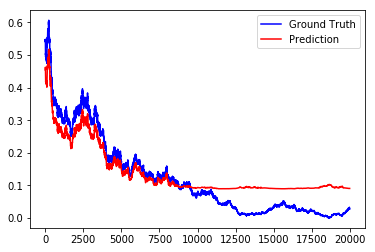

In [22]:
alpha = model.predict(X_test)[:,0]
plt.plot(y_test[:,0], 'b', label='Ground Truth')
plt.plot(alpha, 'r', label='Prediction')
#plt.plot(alpha[:,-1], 'g', label='Forecast')
#plt.plot(alpha - y_test[:,0,np.newaxis], label='Difference')
plt.legend(loc='best')
plt.show()

In [346]:
google, mu, sig = normalize(googdata)

t = unnormalize(google, mu, sig)

In [18]:
google_train, google_test, _, _ = preprocess_data(googdata, window, percent_train = 1)

In [363]:
beta = model.predict(google_train)

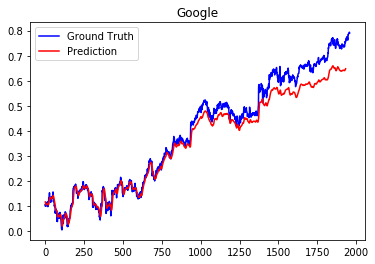

In [391]:
plt.plot(google[window:,0], 'b', label = 'Ground Truth')
plt.plot(beta[:-window,0], 'r', label = 'Prediction')
#plt.plot(beta[:,0] / google[:-26,0] - 1)
#plt.ylim(-0.5,0.5)
plt.title('Google')
plt.legend()
plt.show()

In [259]:
r = model.predict(google_train)

In [411]:
testScore = model.evaluate(google_train, google_test, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Test Score: 14.837807 MSE (3.851987 RMSE)


In [11]:
g = googdata[-250:]

In [14]:
gnorm, zeta, eta = normalize(g)
google_train, google_test, _, _ = preprocess_data(gnorm, window, percent_train = 1, forecast = 1)

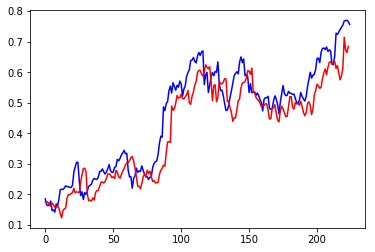

In [46]:
plt.plot(gnorm[window+5:,0], 'b')
plt.plot(model.predict(google_train)[:,0], 'r')
plt.show()

In [47]:
print len(gnorm[26:]), len(google_train)

224 224


In [48]:
print model.evaluate(google_train, google_test, verbose=0)

[9.7172826358250202, 0.10267857142857142]


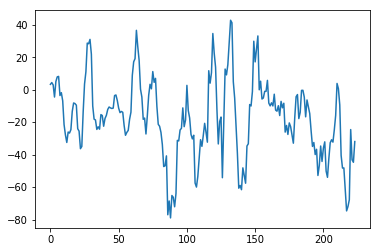

In [68]:
t = model.predict(google_train)
t = unnormalize(t, zeta, eta)
plt.plot(t[:,0] - googdata[-250+window+6:,0])
plt.show()